**Fashion MNIST Dataset Classification Using Neural Networks and Deep Learning**

The Following code will import the necessary libraries.

In [ ]:
import my_utils as mu #importing custom utility 
import torch 
from torch import nn
from IPython import display
import tensorflow as tf

**Task 1 -**The following creates a dataloader of the MNIST fashion dataset.

The data loaders loads the data in batch of 32 images.


In [ ]:
batch_size = 32
train_iter, test_iter = mu.load_data_fashion_mnist(batch_size) #initializing training and testing data loader
type(train_iter) 

  0%|          | 0/26421880 [00:00<?, ?it/s]

Extracting ../data/FashionMNIST/raw/train-images-idx3-ubyte.gz to ../data/FashionMNIST/raw



  0%|          | 0/29515 [00:00<?, ?it/s]

Extracting ../data/FashionMNIST/raw/train-labels-idx1-ubyte.gz to ../data/FashionMNIST/raw



  0%|          | 0/4422102 [00:00<?, ?it/s]

Extracting ../data/FashionMNIST/raw/t10k-images-idx3-ubyte.gz to ../data/FashionMNIST/raw



  0%|          | 0/5148 [00:00<?, ?it/s]

Extracting ../data/FashionMNIST/raw/t10k-labels-idx1-ubyte.gz to ../data/FashionMNIST/raw



/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


torch.utils.data.dataloader.DataLoader

The following code will print the first batch of data from the training set.

In [ ]:
X, y = next(iter(train_iter)) # first batch
print(X.size())
print(y)

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


torch.Size([32, 1, 28, 28])
tensor([0, 9, 3, 0, 9, 8, 3, 5, 2, 6, 7, 7, 6, 0, 5, 1, 5, 6, 8, 1, 1, 0, 2, 0,
        0, 0, 8, 0, 7, 9, 3, 6])


The following is the function definition for a dropout layer. A dropout layer randomly drops connections between neurons, forcing the network to find new paths and generalise.

In [ ]:
def dropout_layer(x, dropout): #x is feature tensor
    assert 0 <= dropout <= 1
    # In this case, all elements are dropped out
    if dropout == 1:
        return torch.zeros_like(x)
    # In this case, all elements are kept
    if dropout == 0:
        return x
    mask = (torch.Tensor(x.shape).uniform_(0, 1) > dropout).float()
    return mask * x / (1.0 - dropout)

**Task 2 -** Following code will extend the torch.nn.Module.Net class and give the definition of the architecture of the neural network. The forward function in the following class implements the stem, the backbone and the classifier of the neural network. It defines how the data flows in the neural network.

In [ ]:
class Net(torch.nn.Module):
    def __init__(self, no_inputs,patch_dim, no_patch, stem_output, mlp_hidden_nodes, backbone_output):
        super(Net, self).__init__() 
        self.no_inputs = no_inputs
        self.patch_dim = patch_dim
        self.no_patch = no_patch
        self.stem_output = stem_output
        self.mlp_hidden_nodes = mlp_hidden_nodes
        self.backbone_output = backbone_output
        self.Stem = nn.Linear(patch_dim, stem_output)
        self.Block1_mlp1_hidden = nn.Linear(no_patch, mlp_hidden_nodes)
        self.Block1_mlp1_g=nn.ReLU()
        self.Block1_mlp1_layer=nn.Linear(mlp_hidden_nodes, no_patch)
        self.Block1_mlp2_hidden = nn.Linear(stem_output, mlp_hidden_nodes)
        self.Block1_mlp2_g=nn.ReLU()
        self.Block1_mlp2_layer=nn.Linear(mlp_hidden_nodes, stem_output)
        self.classifier = nn.Linear(stem_output, 10)
        #self.relu = nn.ReLU()
        
    def forward(self, x): 
        out = torch.Tensor(x.size(dim=0),no_patch, stem_output)
       # print(x.size())
        x = x.view(-1,49, self.patch_dim) #patchifying image data 
        i=0
        while i<x.size(dim=0):
             #Implementation of STEM 
             x_patch = self.Stem(x[i,:,:])
             #Implementation of BACKBONE
             #Block
             #MLP1
             x_patch=x_patch.transpose(0,1)
             #print(x_patch.size())
             x_patch = self.Block1_mlp1_hidden(x_patch)
             x_patch = self.Block1_mlp1_g(x_patch)
             x_patch=dropout_layer(x_patch,0.1)
             x_patch = self.Block1_mlp1_layer(x_patch)
             x_patch=x_patch.transpose(0,1)
             #MlP2
             #print(x_patch.size())
             x_patch = self.Block1_mlp2_hidden(x_patch)
             x_patch = self.Block1_mlp2_g(x_patch)
             x_patch = self.Block1_mlp2_layer(x_patch)
             out[i]=x_patch
             i=i+1
        #Classifier 
        out=torch.mean(out,dim=1) #taking mean of patch features
        out=self.classifier(out)
        return out

The following function will initialize the weights of the layers of the neural network and the bias.

In [ ]:
# Create and initialize your model here:
no_inputs,patch_dim, no_patch, stem_output, mlp_hidden_nodes, backbone_output=784, 16, 49, 100, 150, 100
net = Net(no_inputs,patch_dim, no_patch, stem_output, mlp_hidden_nodes, backbone_output)


Initialiasing the weights of the neural network. 

In [ ]:
# Model instantiation and initialisation 
def init_weights(m):
    if type(m) == nn.Linear: # by checking type we can init different layers in different ways
        torch.nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu')
        torch.nn.init.zeros_(m.bias)
net.apply(init_weights);        

**Task 3 -** The following function will create loss and optimizer functions.

In [ ]:
# Creare your loss here. Use Cross Entropy loss:
loss = nn.CrossEntropyLoss()
lr, wd = 0.4, 0
# Creare your optimizer here. Use SGD with weight decay wd and learning rate lr.
optimizer = torch.optim.SGD(net.parameters(), lr=lr, weight_decay=wd)

**Task 4 -**Scripts for traning the neural network

In [ ]:
def train_ch3(net, train_iter, test_iter, loss, num_epochs, optimizer):  #@save
    """Train a model."""
    animator = Animator(xlabel='epoch', xlim=[1, num_epochs], ylim=[0.3, 0.9],
                        legend=['train loss', 'train acc', 'test acc'])
    for epoch in range(num_epochs):
        train_metrics = train_epoch_ch3(net, train_iter, loss, optimizer)
        test_acc = evaluate_accuracy(net, test_iter)
        animator.add(epoch + 1, train_metrics + (test_acc,))
    train_loss, train_acc = train_metrics
    assert train_loss < 0.5, train_loss
    assert train_acc <= 1 and train_acc > 0.7, train_acc
    assert test_acc <= 1 and test_acc > 0.7, test_acc

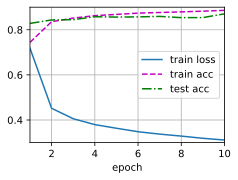

In [ ]:
num_epochs = 10
mu.train_ch3(net, train_iter, test_iter, loss, num_epochs, optimizer)

**Task 5 -** Print the accuracy on the test set.

In [ ]:
mu.evaluate_accuracy(net, test_iter)

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


0.8704